In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [2]:
stud = pd.read_csv('stud_math.csv')
display(stud)
stud.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [3]:
def change_type_column_to_category(df, number_column):
    for column in stud.columns:
        if (column not in number_column) and str(df[column].dtypes)[:5] == 'float':
            df[column] =df[column].astype('Int8', errors= 'ignore').astype(np.str) 
            df[column] = df[column].apply(lambda x: None if x.strip() == '<NA>' else x)
    return df

In [4]:
def count_value(df, column, val):
    if val is None:
        return len(df[df[column].isna()])
    else:
        return len(df[df[column] == val])

In [5]:
def trust_interval(df, column):
    IQR = df[column].quantile(0.75) -  df[column].quantile(0.25)
    perc25 =  df[column].quantile(0.25)
    perc75 =  df[column].quantile(0.75)
    return [perc25 - 1.5*IQR, perc75 + 1.5*IQR]

In [6]:
def plot_trust_interval(df, column, vbins, low, high):
    trust = trust_interval(df, column)
    print(trust)
    l = min(low, trust[0])
    r = max(high, trust[1])
    df[column].loc[(df[column] >= trust[0]) & (df[column] <= trust[1])].hist(
        bins=vbins, range=(l, r), label='IQR')
    df[column].loc[(df[column] <= high) & (df[column] >= low)].hist(
        alpha=0.5, bins=vbins, range=(l, r), label='Здравый смысл')
    plt.legend()

<h2> 1. форматирование данных</h2>

In [7]:
columns = [x.lower()  for x in stud.columns]
stud.columns = columns

In [8]:
stud['age'] = stud['age'].astype(np.int8)
stud['score'] = stud['score'].astype(np.float16)
stud['absences'] = stud['absences'].astype(np.float16)
stud['failures'] = stud['failures'].astype(np.float16)

In [9]:
stud=change_type_column_to_category(stud, ['age', 'failures', 'score', 'absences'])
stud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int8   
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   pstatus              350 non-null    object 
 6   medu                 392 non-null    object 
 7   fedu                 371 non-null    object 
 8   mjob                 376 non-null    object 
 9   fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    object 
 13  studytime            388 non-null    object 
 14  failures             373 non-null    float16
 15  schoolsup            386 non-null    obj

In [10]:
stud

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4,4,at_home,teacher,course,mother,2,2,0.0,yes,no,no,no,yes,-6,yes,NaN,no,4,3,4,3,6.0,30.0
1,GP,F,17,U,GT3,NaN,1,1,at_home,other,course,father,1,2,0.0,no,yes,no,no,no,-6,yes,yes,no,5,3,3,3,4.0,30.0
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3.0,yes,no,NaN,no,yes,-6,yes,yes,NaN,4,3,2,3,10.0,50.0
3,GP,F,15,U,GT3,T,4,2,health,NaN,home,mother,1,3,0.0,no,yes,yes,yes,yes,-9,yes,yes,yes,3,2,2,5,2.0,75.0
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0.0,no,yes,yes,no,yes,-6,yes,no,no,4,3,2,5,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,course,NaN,1,2,2.0,no,yes,yes,no,yes,-6,yes,no,no,5,5,4,4,212.0,45.0
391,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0.0,no,no,no,no,no,-3,yes,yes,no,2,4,5,2,3.0,80.0
392,MS,M,21,R,GT3,T,1,1,other,other,course,NaN,1,1,3.0,NaN,no,no,no,no,-3,NaN,no,no,5,5,3,3,3.0,35.0
393,MS,M,18,R,LE3,T,3,2,services,other,course,mother,3,1,0.0,no,no,no,NaN,no,-3,yes,yes,no,4,4,1,5,0.0,50.0


<h2> 2. Анализ столбца 'studytime, granular'</h2>

In [11]:
stud[stud['studytime'] != stud['studytime, granular']].loc[:,['studytime', 'studytime, granular']]

,studytime,"studytime, granular"
0,2,-6
1,2,-6
2,2,-6
3,3,-9
4,2,-6
...,...,...
390,2,-6
391,1,-3
392,1,-3
393,1,-3


In [12]:
len(stud[(pd.to_numeric(stud['studytime']) * (-3) != pd.to_numeric(stud['studytime, granular'])) & (stud['studytime'].notnull()
                                                  & stud['studytime, granular'].notnull())].index)

0

Столбец granular является копией столбца studytime с коэффициентом -3. Его можно удалить.

In [13]:
stud = stud.drop('studytime, granular', 1)
stud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   age         395 non-null    int8   
 3   address     378 non-null    object 
 4   famsize     368 non-null    object 
 5   pstatus     350 non-null    object 
 6   medu        392 non-null    object 
 7   fedu        371 non-null    object 
 8   mjob        376 non-null    object 
 9   fjob        359 non-null    object 
 10  reason      378 non-null    object 
 11  guardian    364 non-null    object 
 12  traveltime  367 non-null    object 
 13  studytime   388 non-null    object 
 14  failures    373 non-null    float16
 15  schoolsup   386 non-null    object 
 16  famsup      356 non-null    object 
 17  paid        355 non-null    object 
 18  activities  381 non-null    object 
 19  nursery     379 non-null    o

<h2>3. Обработка количественных столбцов, удаление выбросов </h2.

<h3>возраст</h3>

In [14]:
stud.age.value_counts()

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64

In [15]:
count_value(stud, 'age', None)

0

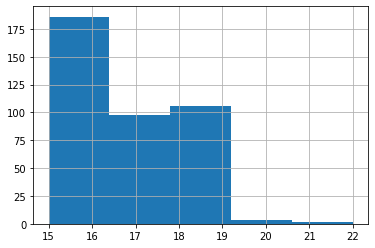

In [16]:
stud.age.hist(bins=5)

[13.0, 21.0]


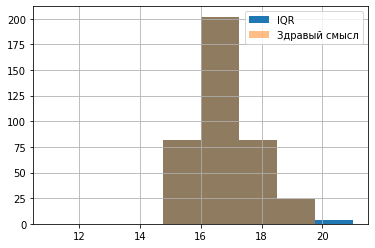

In [17]:
plot_trust_interval(stud, 'age', 8, 11, 19)

Пустых значений нет, выбросы > 20 можно удалить

In [18]:
stud = stud.loc[stud.age <= 19]

<h3>количество пропущенных занятий</h3>

In [19]:
stud.absences.value_counts()

0.0      110
2.0       60
4.0       52
6.0       31
8.0       21
10.0      17
14.0      12
12.0      12
3.0        7
7.0        6
16.0       6
18.0       5
5.0        5
20.0       4
1.0        3
22.0       3
9.0        3
15.0       2
13.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
17.0       1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
28.0       1
Name: absences, dtype: int64

In [20]:
count_value(stud, 'absences', None)

12

Пропусков мало, заполним медианой

In [21]:
stud.absences = stud.absences.fillna(stud.absences.median())

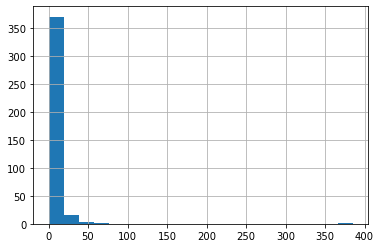

In [22]:
stud.absences.hist(bins=20)

[-12.0, 20.0]


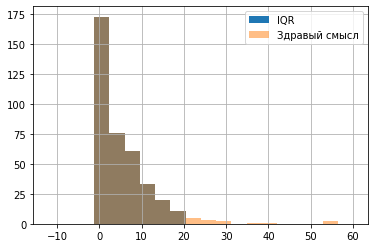

In [23]:
plot_trust_interval(stud, 'absences', 20, 0, 60)

Количество пропусков > 60 - выбросы, удаляем

In [24]:
stud = stud.loc[stud.absences <= 60]

<h3>баллы за экзамен по математике</h3>

In [25]:
stud.score.value_counts()

50.0     54
55.0     46
0.0      37
75.0     32
65.0     31
60.0     31
40.0     30
70.0     27
45.0     25
80.0     16
30.0     15
90.0     11
35.0      8
25.0      7
85.0      5
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

In [26]:
count_value(stud, 'score', None)

6

Пропусков мало, заполним медианой

In [27]:
stud.score = stud.score.fillna(stud.score.median())

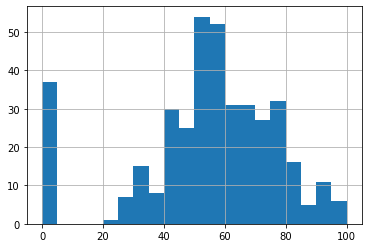

In [28]:
stud.score.hist(bins=20)

[0.625, 105.625]


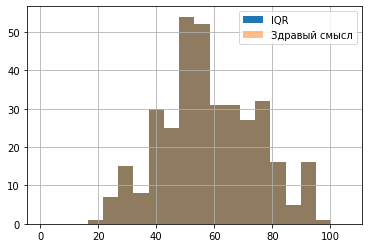

In [29]:
plot_trust_interval(stud, 'score', 20, 1, 100)

0 - выброс, удаляем

In [30]:
stud = stud.loc[stud.score > 0]

<h3>внеучебные неудачи</h3>

In [31]:
stud.failures.value_counts()

0.0    273
1.0     39
2.0     10
3.0      9
Name: failures, dtype: int64

In [32]:
count_value(stud, 'failures', None)

20

Согласно описанию и большому количеству 0 заполним 0

In [33]:
stud.failures = stud.failures.fillna(0)

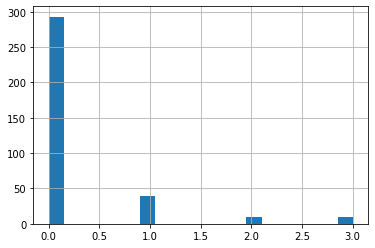

In [34]:
stud.failures.hist(bins=20)

[0.0, 0.0]


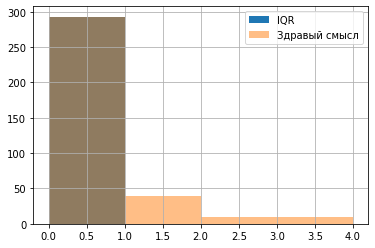

In [35]:
plot_trust_interval(stud, 'failures', 4, 0, 4)

0 - составляет большую часть данных, но по соображениям здравого смысла покастоит оставить все значения

<h2>4. Заполняем пропуски</h2>

In [36]:
# смотрим количество уникальных значений,
# проверяем сколько значений встречаются больше 10%,
# если 1, то заполняем пропуск частым значением, иначе None
for col in stud.columns:
    if stud[col].dtype.name == 'object':
        p10 = stud[col].count() * 0.1
        nuniq = stud[col].nunique()
        nfreq = (stud[col].value_counts() > p10).sum()
        freq_value = stud[col].value_counts().index[0]
        count_na = count_value(stud, col, None) 
        print(col, '(',nuniq  
              , nfreq, freq_value,
              ') -', count_na)
        if nfreq == 1:
            stud[col] = stud[col].fillna(freq_value)
        else:
            stud[col] = stud[col].astype(str).apply(lambda x: None if x.strip() == '' else x) 


school ( 2 2 GP ) - 0
sex ( 2 2 F ) - 0
address ( 2 2 U ) - 15
famsize ( 2 2 GT3 ) - 24
pstatus ( 2 1 T ) - 41
medu ( 5 4 4 ) - 2
fedu ( 6 4 2 ) - 21
mjob ( 5 4 other ) - 17
fjob ( 5 2 other ) - 32
reason ( 4 3 course ) - 15
guardian ( 3 2 mother ) - 26
traveltime ( 4 2 1 ) - 23
studytime ( 4 3 2 ) - 7
schoolsup ( 2 2 no ) - 8
famsup ( 2 2 yes ) - 35
paid ( 2 2 no ) - 37
activities ( 2 2 yes ) - 12
nursery ( 2 2 yes ) - 13
higher ( 2 1 yes ) - 18
internet ( 2 2 yes ) - 29
romantic ( 2 2 no ) - 29
famrel ( 6 3 4 ) - 23
freetime ( 5 3 3 ) - 10
goout ( 5 4 3 ) - 7
health ( 5 5 5 ) - 13


In [37]:
stud.describe()

,age,failures,absences,score
count,351.000000,351.000000,351.000000,351.00000
mean,16.601140,0.244995,6.085938,57.65625
std,1.183409,0.630371,7.312500,15.93750
min,15.000000,0.000000,0.000000,20.00000
25%,16.000000,0.000000,2.000000,50.00000
50%,17.000000,0.000000,4.000000,55.00000
75%,18.000000,0.000000,8.000000,70.00000
max,19.000000,3.000000,56.000000,100.00000


In [38]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      351 non-null    object 
 1   sex         351 non-null    object 
 2   age         351 non-null    int8   
 3   address     351 non-null    object 
 4   famsize     351 non-null    object 
 5   pstatus     351 non-null    object 
 6   medu        351 non-null    object 
 7   fedu        351 non-null    object 
 8   mjob        351 non-null    object 
 9   fjob        351 non-null    object 
 10  reason      351 non-null    object 
 11  guardian    351 non-null    object 
 12  traveltime  351 non-null    object 
 13  studytime   351 non-null    object 
 14  failures    351 non-null    float16
 15  schoolsup   351 non-null    object 
 16  famsup      351 non-null    object 
 17  paid        351 non-null    object 
 18  activities  351 non-null    object 
 19  nursery     351 non-null    o

In [39]:
stud

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,nan,A,4,4,at_home,teacher,course,mother,2,2,0.0,yes,no,no,no,yes,yes,nan,no,4,3,4,3,6.0,30.0
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0.0,no,yes,no,no,no,yes,yes,no,5,3,3,3,4.0,30.0
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3.0,yes,no,nan,no,yes,yes,yes,nan,4,3,2,3,10.0,50.0
3,GP,F,15,U,GT3,T,4,2,health,nan,home,mother,1,3,0.0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,5,2.0,75.0
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0.0,no,yes,yes,no,yes,yes,no,no,4,3,2,5,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,MS,F,18,R,GT3,T,4,4,teacher,at_home,reputation,mother,3,1,0.0,no,yes,yes,yes,yes,yes,yes,yes,4,4,3,5,7.0,30.0
388,MS,F,18,U,LE3,T,3,1,teacher,services,course,mother,1,2,0.0,no,yes,yes,no,yes,yes,yes,no,4,3,4,1,0.0,40.0
391,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0.0,no,no,no,no,no,yes,yes,no,2,4,5,2,3.0,80.0
393,MS,M,18,R,LE3,T,3,2,services,other,course,mother,3,1,0.0,no,no,no,nan,no,yes,yes,no,4,4,1,5,0.0,50.0


<h2>5. корреляционный анализ</h2>

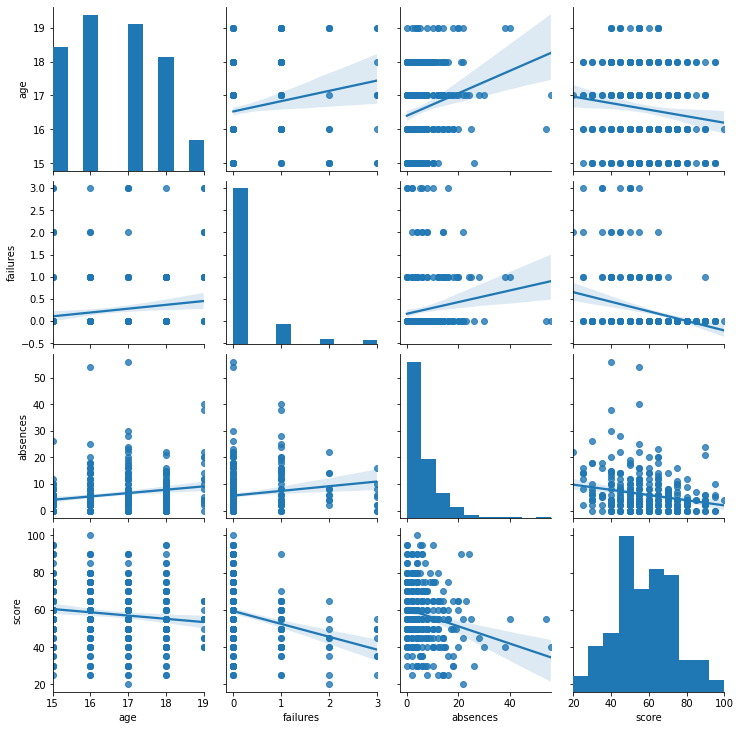

In [40]:
sns.pairplot(stud, kind = 'reg')

In [41]:
stud.corr()

,age,failures,absences,score
age,1.000000,0.162105,0.204796,-0.130267
failures,0.162105,1.000000,0.152171,-0.273204
absences,0.204796,0.152171,1.000000,-0.212929
score,-0.130267,-0.273204,-0.212929,1.000000


<h2>6. номинативные переменные</h2>

In [42]:
def get_stat_dif(df, column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if (ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], 
                      df.loc[df.loc[:, column] == comb[1], 'score']).pvalue
                <= 0.05/len(combinations_all)):
            print('Найдены статистически значимые различия для колонки', column)
            break

In [43]:
for col in stud.columns:
    get_stat_dif(stud, col)

C:\DataScience\anaconda3\lib\site-packages\numpy\core\_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\DataScience\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\DataScience\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\DataScience\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки goout
Найдены статистически значимые различия для колонки score


In [44]:
stud_for_model = stud.loc[:, ['age', 'failures', 'absences', 'sex', 'medu', 'mjob', 'studytime', 'goout', 'score']]
stud_for_model.head()

,age,failures,absences,sex,medu,mjob,studytime,goout,score
0,18,0.0,6.0,F,4,at_home,2,4,30.0
1,17,0.0,4.0,F,1,at_home,2,3,30.0
2,15,3.0,10.0,F,1,at_home,2,2,50.0
3,15,0.0,2.0,F,4,health,3,2,75.0
4,16,0.0,4.0,F,3,other,2,2,50.0


<b>Вывод:</b> 
- В данных достаточно мало пустых значений.
- Часть числовых данных, на самом деле являются категориальными признаками, изменим им тип.
- Выбросы найдены на всех оставшихся количественных признаках. Но failures нельзя очистить от выбросов (возможно это все таки категориальный признак).
- При увеличении числа пропусков или внеучебных неудач или возраста оценка снижается
- Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это 'age', 'failures', 'absences', 'sex', 'medu', 'mjob', 'studytime', 'goout', 'score'